In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Concatenate

In [3]:
train_dir = "/kaggle/input/dataset/train-20240304T174029Z-001/train"
test_dir = "/kaggle/input/dataset/test-20240304T173754Z-001/test"

In [4]:
img_size = (224, 224)
batch_size = 64

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5994 images belonging to 200 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5794 images belonging to 200 classes.


In [22]:
from tensorflow.keras.regularizers import l2
# Custom MobileNetV2 Model with Fine-Tuning and Regularization
def create_custom_mobilenetv2(img_size, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:-10]:  # Fine-tune more layers
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.45)(x)  # Regularization with dropout
    output = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.024))(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [23]:
# Compile the model
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = create_custom_mobilenetv2(img_size, num_classes=200) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:

model = create_custom_mobilenetv2(img_size, num_classes=200) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
import tensorflow as tf 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history= model.fit(train_generator,
    epochs=100,
    steps_per_epoch = (5994 // batch_size),
    validation_data=test_generator,
    validation_steps = (5794 // batch_size),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
93/93 [==============================] - 135s 1s/step - loss: 7.8843 - accuracy: 0.0841 - val_loss: 4.9818 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 2/100
93/93 [==============================] - 121s 1s/step - loss: 4.3097 - accuracy: 0.2676 - val_loss: 4.6868 - val_accuracy: 0.1887 - lr: 0.0010
Epoch 3/100
93/93 [==============================] - 121s 1s/step - loss: 3.6095 - accuracy: 0.3452 - val_loss: 5.0399 - val_accuracy: 0.1502 - lr: 0.0010
Epoch 4/100
93/93 [==============================] - 121s 1s/step - loss: 3.3316 - accuracy: 0.3987 - val_loss: 5.0433 - val_accuracy: 0.1550 - lr: 0.0010
Epoch 5/100
93/93 [==============================] - 121s 1s/step - loss: 3.1914 - accuracy: 0.4266 - val_loss: 5.0765 - val_accuracy: 0.1632 - lr: 0.0010
Epoch 6/100
93/93 [==============================] - 121s 1s/step - loss: 2.9232 - accuracy: 0.5138 - val_loss: 3.7330 - val_accuracy: 0.2946 - lr: 1.0000e-04
Epoch 7/100
93/93 [==============================] - 121s 1s/step 

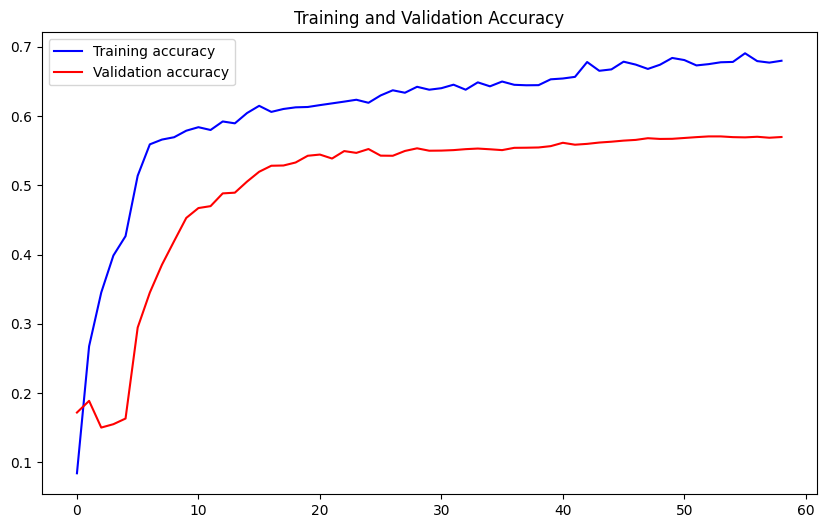

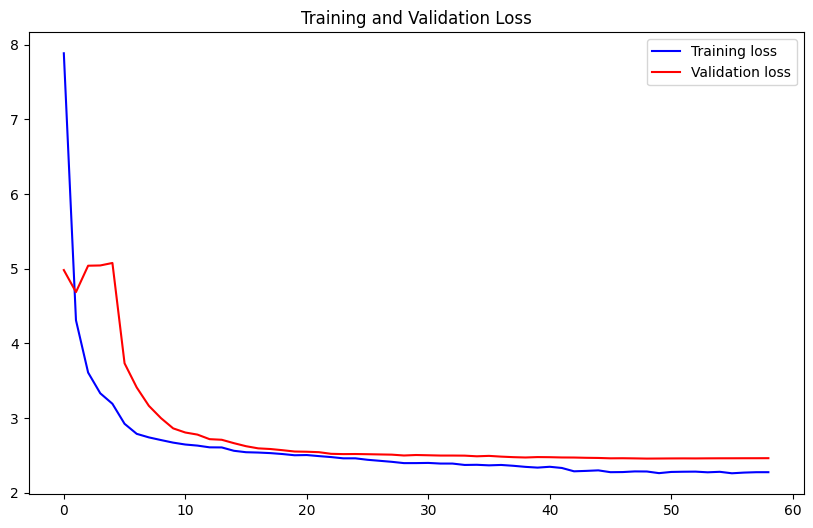

In [27]:
# Extract accuracy and loss from the training history:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get the number of epochs

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# # Assuming you have verified the Early Stopping patience
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) 

# # Calculate steps_per_epoch correctly
# total_images = 5994  # Replace with your actual dataset size
# batch_size = 64
# steps_per_epoch = total_images // batch_size

# # Training 
# custom_model.fit(train_generator,
#     epochs=20,  # Train for the desired number of epochs
#     steps_per_epoch=steps_per_epoch,
#     validation_data=test_generator, 
#     validation_steps=test_generator.samples // batch_size,
#     callbacks=[reduce_lr, early_stopping]) 

In [29]:
training_log = history.history

In [30]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(training_log, f)

In [31]:
import pandas as pd

log_df = pd.DataFrame(history.history) 

In [32]:
log_df.to_csv('training_history.csv')

In [33]:
model.save('Bird_model.h5')

In [34]:
from keras.models import load_model

# Load your model
model = load_model('Bird_model.h5')

# Print the model summary
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           